# Age estimation using a CNN and UTKFace

The UTKFace data set used is the one available [here](https://susanqq.github.io/UTKFace/). The 3 sets were downloaded put into a UTKFace folder as part1, part2, part3.

In [22]:
import os # For directory and file path operations
import re # For regex pattern matching

import matplotlib.pyplot as plt
import numpy as np

# Basic CNN setup and training
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Loading the image data and extracting the features from the file name

In [23]:
# Path to the UTKFace dataset
utkface_dir = 'UTKFace'

image_paths = []
ages = []
genders = []
races = []

# Regex to extract labels from filename
pattern = re.compile(r'^(\d+)_(\d+)_(\d+)_')

for part in ['part1', 'part2', 'part3']:
    part_dir = os.path.join(utkface_dir, part)
    if not os.path.isdir(part_dir):
        continue
    for fname in os.listdir(part_dir):
        match = pattern.match(fname)
        if match:
            age, gender, race = map(int, match.groups())
            image_paths.append(os.path.join(part_dir, fname))
            ages.append(age)
            genders.append(gender)
            races.append(race)

print(f'Total images loaded: {len(image_paths)}')
if image_paths:
    print(f'Example: {image_paths[0]}, Age: {ages[0]}, Gender: {genders[0]}, Race: {races[0]}')

Total images loaded: 24104
Example: UTKFace/part1/16_1_3_20170104222158160.jpg, Age: 16, Gender: 1, Race: 3


## Data exploration

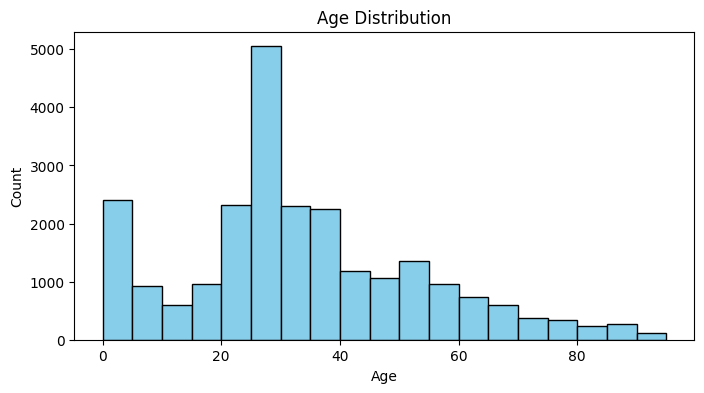

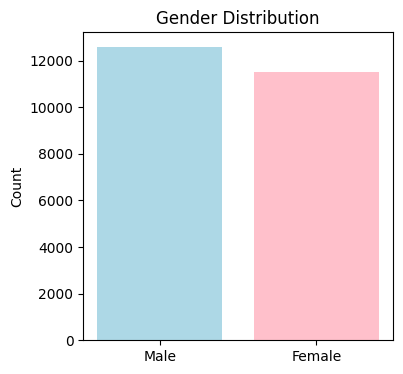

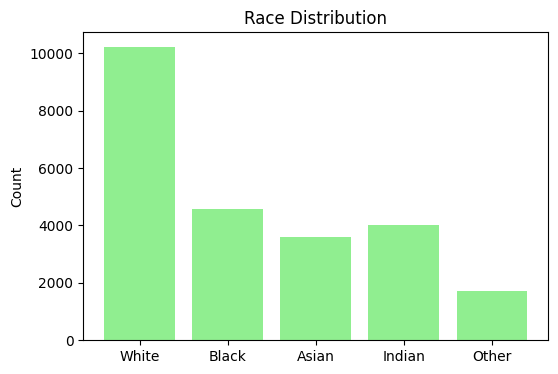

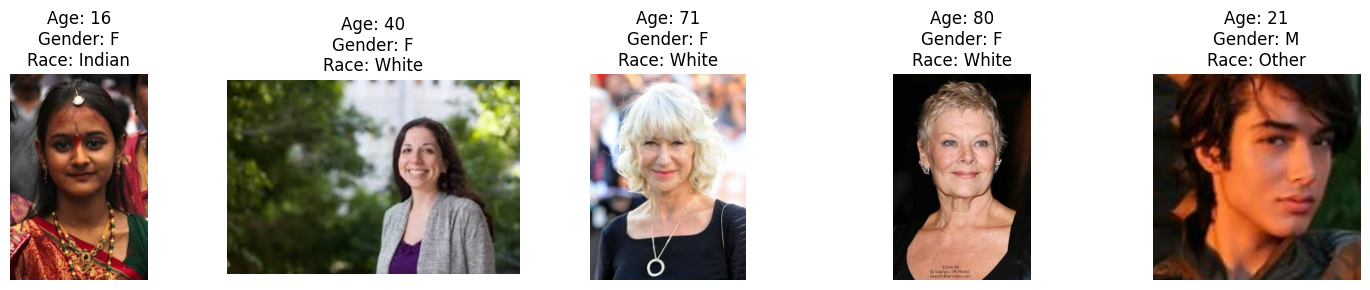

In [24]:
plt.figure(figsize=(8,4))
plt.hist(ages, bins=range(0, 100, 5), color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Gender distribution
plt.figure(figsize=(4,4))
plt.bar(['Male', 'Female'], [genders.count(0), genders.count(1)], color=['lightblue', 'pink'])
plt.title('Gender Distribution')
plt.ylabel('Count')
plt.show()

# Race distribution
race_labels = ['White', 'Black', 'Asian', 'Indian', 'Other']
race_counts = [races.count(i) for i in range(len(race_labels))]
plt.figure(figsize=(6,4))
plt.bar(race_labels, race_counts, color='lightgreen')
plt.title('Race Distribution')
plt.ylabel('Count')
plt.show()

# Show a few sample images with labels
import matplotlib.image as mpimg
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, ax in enumerate(axes):
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Age: {ages[i]}\nGender: {"M" if genders[i]==0 else "F"}\nRace: {race_labels[races[i]]}')
plt.tight_layout()
plt.show()

## Data transformations and slicing

Because the amount of data is very big use a smaller set for training

In [25]:
# Use a smaller random subset of the data for faster experimentation
subset_size = 4000  # Change this number as needed
np.random.seed(42)
indices = np.random.choice(len(image_paths), size=subset_size, replace=False)

image_paths = [image_paths[i] for i in indices]
ages = [ages[i] for i in indices]
genders = [genders[i] for i in indices]
races = [races[i] for i in indices]

print(f'Using a subset of {subset_size} images.')

Using a subset of 4000 images.


## Load and preprocess


In [ ]:
# Parameters
img_size = 64  # Resize images to 64x64

# Load and preprocess images
X = []
for path in image_paths:
    img = load_img(path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    X.append(img)
X = np.array(X)
y = np.array(ages)  # Use ages as regression target

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN layers
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Single output because it's regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 516.1183 - mae: 17.5284 - val_loss: 424.7469 - val_mae: 15.6743
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 516.1183 - mae: 17.5284 - val_loss: 424.7469 - val_mae: 15.6743
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 399.3390 - mae: 15.5129 - val_loss: 433.0196 - val_mae: 15.7786
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 399.3390 - mae: 15.5129 - val_loss: 433.0196 - val_mae: 15.7786
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 365.7854 - mae: 14.8807 - val_loss: 368.7183 - val_mae: 14.8193
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 365.7854 - mae: 14.8807 - val_loss: 368.7183 - val_mae: 14.8193
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 355.6704 - mae: 14.6583 - val_loss: 359.8635 - val_mae: 14.7601
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 355.6704 - mae: 14.6583 - val_loss: 359.8635 - val_mae: 14.7601
Epoch 5/

## Validation and visualization

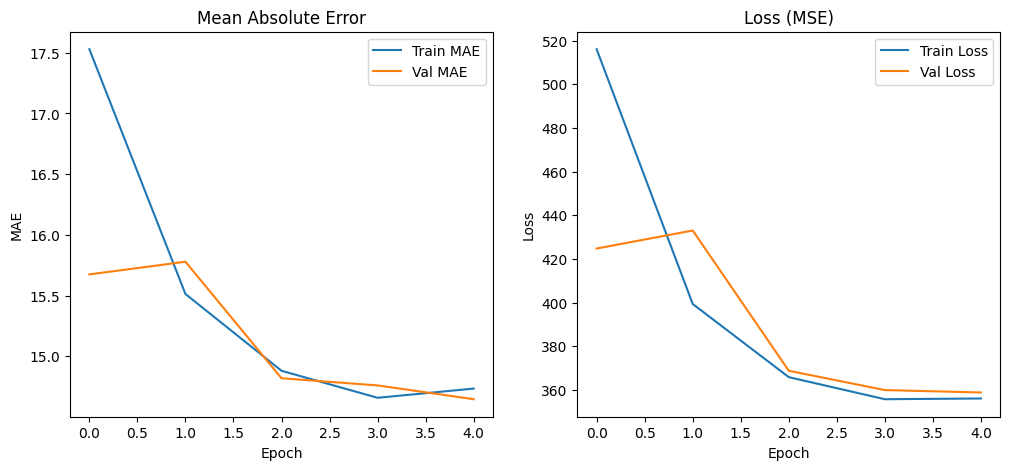

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


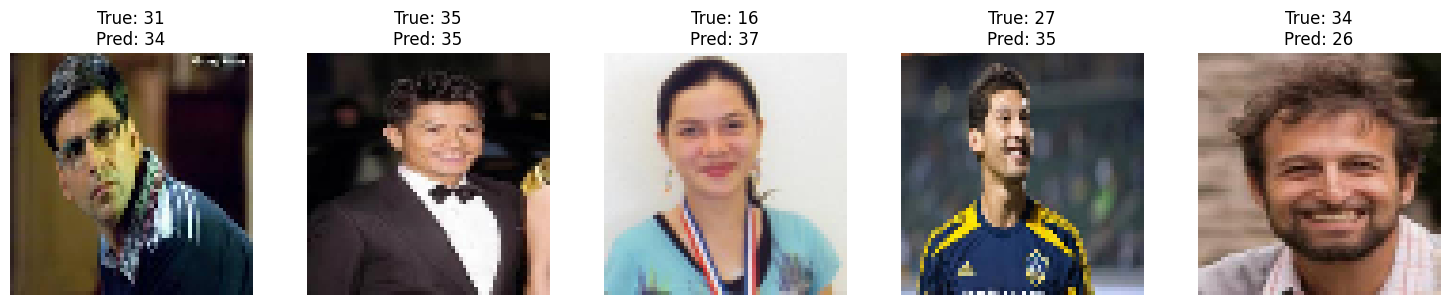

In [27]:
# Plot training & validation MAE/loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict and show a few validation images with predicted and true ages
preds = model.predict(X_val).flatten()

fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, ax in enumerate(axes):
    ax.imshow(X_val[i])
    ax.axis('off')
    ax.set_title(f'True: {int(y_val[i])}\nPred: {int(preds[i])}')
plt.tight_layout()
plt.show()